## About this notebook!!!
This notebook shows a simple, scalar implementation of the [Split-Step Fourier Method](https://en.wikipedia.org/wiki/Split-step_method) for solving the [Nonlinear Schrodinger Equation](https://https://en.wikipedia.org/wiki/Nonlinear_Schr%C3%B6dinger_equation),

$\frac{\partial A}{\partial z}=-\frac{\alpha}{2}A-i \frac{\beta_2}{2} \frac{\partial^2 A}{\partial T^2}+i\gamma|A|^2A$.

This nonlinear partial differential equation models how the envelope and phase of light pulse changes when propagating through an optical fiber, when taking power attenuation ($\alpha$), Group Velocity Dispersion ($\beta_2$) and waveguide nonlinearity ($\gamma$) causing Self-Phase Modulation (SPM) into account. 

If you are just starting your graduate studies in nonlinear optics, I encourage you to write your own implementation from scratch in a programming language of your choice as it's a great way to learn about the many exotic effects that can take place in optical fibers. 

This implementation contains a number of "TODO's" in the comments, which suggest features that a moderately experienced programmer should be able to implement without too much trouble. Consider downloading a copy of this notebook from my [GitHub page ](https://github.com/OleKrarup123/NLSE-vector-solver/blob/main/SSFM.ipynb), so you can play around with it on your own. 

If you want to learn more about experimental fiber optics, more than 20 tutorial videos are available on my [YouTube page](https://https://youtube.com/playlist?list=PLdFybGSAoPnnPkzL8zq6uR1yYZk4Ut_Zv). 


## Import useful libraries

In [1]:
import numpy as np
from scipy.fftpack import fft, ifft, fftshift, ifftshift, fftfreq

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

global pi; pi=np.pi 

## Define simulation parameters


In [2]:
N  = 2**15 #Number of points
dt = 0.1e-12 #Time resolution [s] 



## 图片风格

In [3]:
params = {
        "text.color" : "EF2F88",  # 文本颜色
        "axes.labelcolor" : "EF2F88",   # x and y labels 坐标轴标题颜色
        "xtick.color" : "EF2F88",        # x轴刻度和数值颜色
        "ytick.color" : "EF2F88",     # y轴刻度和数值颜色
        'axes.edgecolor': '(0, 0, 0, 0)',     # 图边框颜色'purple'
        'legend.framealpha': 0,     # 图例透明度
        'legend.edgecolor': 'EF2F88',  # 图例边框颜色
        'legend.facecolor': '(0, 0, 0, 0)',  # 图例背景颜色
        
        "font.family": "serif",  # 使用衬线体
        "font.serif": ["Times New Roman"],  # 全局默认使用衬线宋体 "SimHei"黑体
        
        # "font.family": "sans-serif",  # 使用无衬线体
        # "font.sans-serif": ["Tahoma"],  # 全局默认使用衬线宋体 "SimHei"黑体
        
        "font.weight": 'normal' , #bold粗体,bolder更粗,lighter更细.400等同于normal700等同于bold
        "font.size": 14,  # 五号，10.5磅 .'medium',#or large,small
        "axes.unicode_minus": False,
        "mathtext.fontset": "stix",  # 设置 LaTeX 字体，stix 近似于 Times 字体
          }
plt.rcParams.update(params)

## Define function for getting FFT frequency range from time vector

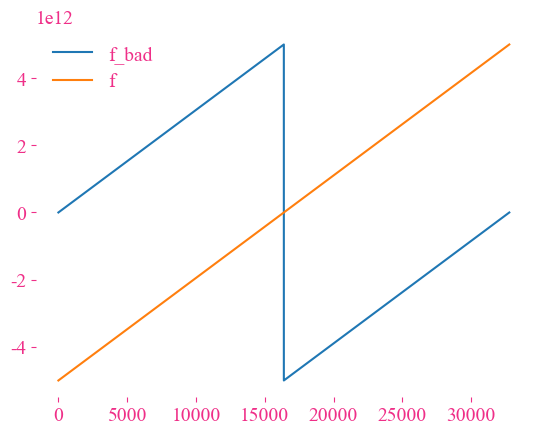

In [4]:
def getFreqRangeFromTime(time):
    return fftshift(fftfreq(len(time), d=time[1]-time[0]))


t=np.linspace(0,N*dt,N) #Time step array
t=t-np.mean(t)          #Center so middle entry is t=0

f_bad = fftfreq(len(t), d=t[1]-t[0]) 
f=getFreqRangeFromTime(t)



plt.figure()
plt.plot(f_bad,label="f_bad")
plt.plot(f,label="f")
plt.legend()
plt.show()

#NOTE: scipy is (for some reason) coded so the first entry is freq=0, the next 
#(N-1)/2 are all the positive frequencies and the remaining ones are the 
#negative ones. The function, fftshift, rearranges the entries so negative 
#frequencies come first

## Define functions for getting phase and chirp

In [5]:
def getPhase(pulse):
    phi=np.unwrap(np.angle(pulse)) #Get phase starting from 1st entry
    phi=phi-phi[int(len(phi)/2)]   #Center phase on middle entry
    return phi    


def getChirp(time,pulse):
    phi=getPhase(pulse)
    dphi=np.diff(phi ,prepend = phi[0] - (phi[1]  - phi[0]  ),axis=0) #Change in phase. Prepend to ensure consistent array size 
    dt  =np.diff(time,prepend = time[0]- (time[1] - time[0] ),axis=0) #Change in time.  Prepend to ensure consistent array size

    return -1.0/(2*pi)*dphi/dt #Chirp = - 1/(2pi) * d(phi)/dt

    
     

In [6]:
a=np.array([0-1j,1+0j,0+1j])
ph=getPhase(a)
print(ph)
print(type(ph[0]))
ch=getChirp(np.array([-1.0,0.0,1.0]),a)
print(ch)
print(type(ch[0]))

[-1.57079633  0.          1.57079633]
<class 'numpy.float64'>
[-0.25 -0.25 -0.25]
<class 'numpy.float64'>


## Define class to hold simulation parameters

In [7]:
#Class for holding info about the simulation params
class SIM_config:
    def __init__(self,N,dt):
        self.number_of_points=N # 计算的点数N
        self.time_step=dt # 时间步长dt
        t=np.linspace(0,N*dt,N) # 时间数组t
        self.t=t-np.mean(t) # 中心化，中间的点为t=0
        self.tmin=self.t[0] # 最小时间tmin
        self.tmax=self.t[-1] # 最大时间tmax
        
        self.f=getFreqRangeFromTime(self.t) # 频率数组f
        self.fmin=self.f[0] # 最小频率fmin
        self.fmax=self.f[-1] # 最大频率fmax
        self.freq_step=self.f[1]-self.f[0] # 频率步长freq_step

        self.describe_config()
        
    def describe_config(self):
        print("### Configuration Parameters ###")
        print(f" Number of points = {self.number_of_points}")
        print(f" Start time, tmin = {self.tmin*1e12}ps")
        print(f" Stop time, tmax = {self.tmax*1e12}ps")
        print(f" Time resolution, dt = {self.time_step*1e12}ps")
        print("  ")
        print(f" Start frequency= {self.fmin/1e12}THz")
        print(f" Stop frequency = {self.fmax/1e12}THz")
        print(f" Frequency resolution= {self.freq_step/1e6}MHz")
        print( "   ")

#Initialize class
sim_config=SIM_config(N,dt)

### Configuration Parameters ###
 Number of points = 32768
 Start time, tmin = -1638.4ps
 Stop time, tmax = 1638.4ps
 Time resolution, dt = 0.1ps
  
 Start frequency= -4.9998474121143825THz
 Stop frequency = 4.999542245646358THz
 Frequency resolution= 305.1664680244141MHz
   


## Functions for creating a Gaussian pulse to be simulated

In [8]:
#Function returns pulse power or spectrum PSD
def getPower(amplitude):
    return np.abs(amplitude)**2  

#Function gets the energy of a pulse pulse or spectrum by integrating the power
def getEnergy(time_or_frequency,amplitude):
    return np.trapz(getPower(amplitude),time_or_frequency)

#TODO: Add support for different carrier frequencies. Hint: Multiply by complex exponential!
#TODO: Add support for pre-chirped pulses. 
def GaussianPulse(time,amplitude,duration,offset,chirp,order):
  assert 1 <= order, f"Error: Order of gaussian pulse is {order}. Must be >=1"
  return amplitude*np.exp(- (1+1j*chirp)/2*((time-offset)/(duration))**(2*np.floor(order)))*(1+0j)



## Test functions:

In [9]:


#Initialize Gaussian pulse
amplitude = 1                       #Amplitude in units of sqrt(W)
duration  = 2**7*sim_config.time_step   #Pulse 1/e^2 duration [s]
offset    = 0                       #Time offset
testChirp = 0
testOrder = 1
testCarrierFreq=0
testPulse=GaussianPulse(t, amplitude, duration, offset,testChirp,testOrder)

super_order=10
testPulse_super=GaussianPulse(t, amplitude, duration, offset,testChirp,super_order)

testPulse_chrip=GaussianPulse(t, amplitude, duration, offset,1,1)



### Test 1: Gaussian pulse

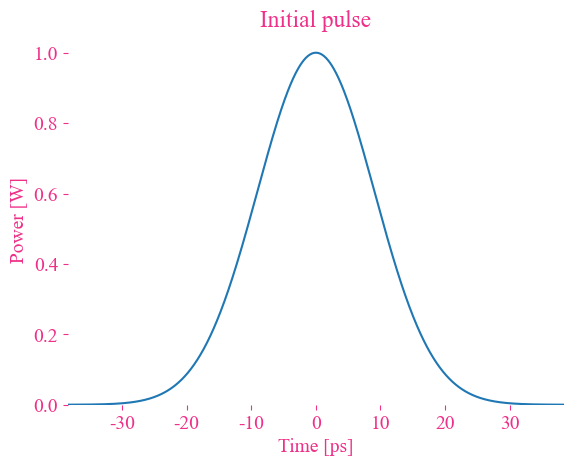

In [10]:
plt.figure()
plt.title("Initial pulse")
plt.plot(sim_config.t*1e12,getPower(testPulse))
plt.xlabel("Time [ps]")
plt.ylabel("Power [W]")
plt.axis([-duration*3*1e12,duration*3*1e12,0,1.05*amplitude**2])
plt.show()
# plt.savefig("Initial pulse.pdf")


### Test 2: Gaussian pulse Chirped

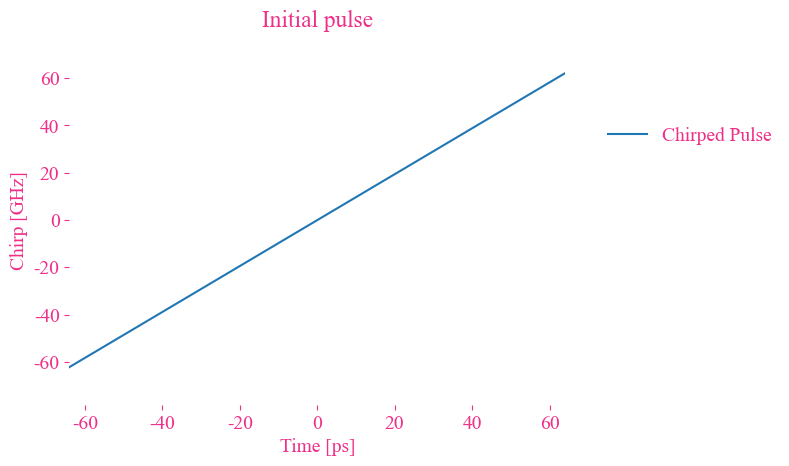

In [11]:
plt.figure()
plt.title("Initial pulse")
plt.plot(sim_config.t*1e12,getChirp(sim_config.t,testPulse_chrip)/1e9,label='Chirped Pulse')
plt.xlabel("Time [ps]")
plt.ylabel("Chirp [GHz]")
plt.axis([-duration*5*1e12,duration*5*1e12,-1/duration/1e9,1/duration/1e9])
plt.legend(bbox_to_anchor=(1.05,0.8))
plt.show()

## Function for getting the spectrum corresponding to a given pulse

In [12]:
def getSpectrumFromPulse(time,pulse_amplitude):
    pulseEnergy=getEnergy(time,pulse_amplitude) #Get pulse energy
    f=getFreqRangeFromTime(time) 
    dt=time[1]-time[0]
    
    spectrum_amplitude=fftshift(fft(pulse_amplitude))*dt #Take FFT and do shift
    spectrumEnergy=getEnergy(f, spectrum_amplitude) #Get spectrum energy
    
    err=np.abs((pulseEnergy/spectrumEnergy-1))
    
    assert( err<1e-7 ), f'ERROR = {err}: Energy changed when going from Pulse to Spectrum!!!' 
    
    return spectrum_amplitude



#Equivalent function for getting time base from frequency range
def getTimeFromFrequency(frequency):  
    return fftshift(fftfreq(len(frequency), d=frequency[1]-frequency[0]))


#Equivalent function for getting pulse from spectrum
def getPulseFromSpectrum(frequency,spectrum_amplitude):
    
    spectrumEnergy=getEnergy(frequency, spectrum_amplitude)
    
    time = getTimeFromFrequency(frequency)
    dt = time[1]-time[0]
     
    pulse = ifft(ifftshift(spectrum_amplitude))/dt
    pulseEnergy = getEnergy(time, pulse)
    
    err=np.abs((pulseEnergy/spectrumEnergy-1))

    assert( err<1e-7   ), f'ERROR = {err}: Energy changed when going from Spectrum to Pulse!!!' 
    
    return pulse

#Equivalent function for generating a Gaussian spectrum
def GaussianSpectrum(frequency,amplitude,bandwidth):
    time = getTimeFromFrequency(frequency)
    return getSpectrumFromPulse(time, GaussianPulse(time, amplitude, 1/bandwidth, 0,0,1))

## Test functions

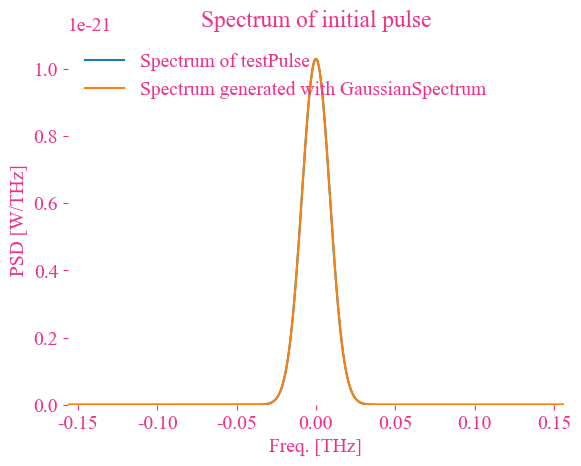

In [13]:

testSpectrum=getSpectrumFromPulse(sim_config.t,testPulse)
testSpectrum_2=GaussianSpectrum(sim_config.f,amplitude,1/duration)


plt.figure()
plt.title("Spectrum of initial pulse")
plt.plot(sim_config.f/1e12,getPower(testSpectrum),label="Spectrum of testPulse")
plt.plot(sim_config.f/1e12,getPower(testSpectrum_2),label="Spectrum generated with GaussianSpectrum")
plt.axis([-1/duration*2/1e12,1/duration*2/1e12,0,1.1e-21])
plt.xlabel("Freq. [THz]")
plt.ylabel("PSD [W/THz]")
plt.legend(loc='upper left')
plt.show()




## Set up properties of the fiber

In [14]:
#Class for holding info about the fiber
class Fiber_config:
  def __init__(self,nsteps,L,gamma,beta2,alpha_dB_per_m):
      self.nsteps=nsteps # 光纤长度分割的步数
      self.ntraces = self.nsteps+1 #Note: If we want to do 100 steps, we will get 101 calculated pulses (zeroth at the input + 100 computed ones)
      self.Length=L # 光纤长度单位m
      self.dz=L/nsteps # 每一步的长度
      self.zlocs=np.linspace(0,L,self.ntraces) #Locations of each calculated pulse# 每一步的位置
      self.gamma=gamma # 非线性参数
      self.beta2=beta2 # 色散参数
      self.alpha_dB_per_m=alpha_dB_per_m # 衰减系数
      self.alpha_Np_per_m = self.alpha_dB_per_m*np.log(10)/10.0 #Loss coeff is usually specified in dB/km, but Nepers/km is more useful for calculations
      #TODO: Make alpha frequency dependent.  
  
#Define fiberulation parameters
Length          = 1e3      #Fiber length in m
nsteps          = 2**8     #Number of steps we divide the fiber into # 2**8=256 光纤长度分割的步数

gamma           = 10e-3     #Nonlinearity parameter in 1/W/m 
beta2           = 100e3    #Dispersion in fs^2/m (units typically used when referring to beta2) 
beta2          *= (1e-30)  #Convert fs^2 to s^2 so everything is in SI units
alpha_dB_per_m  = 0.2e-3   #Power attenuation coeff in decibel per m. Usual value at 1550nm is 0.2 dB/km

#Note:  beta2>0 is normal dispersion with red light pulling ahead, 
#       causing a negative leading chirp
#       
#       beta2<0 is anormalous dispersion with blue light pulling ahead, 
#       causing a positive leading chirp.

  
#  Initialize class
fiber=Fiber_config(nsteps, Length, gamma, beta2, alpha_dB_per_m)





## Define SSFM function

In [15]:
#TODO: Make returning the full matrices optional

def SSFM(fiber:Fiber_config,sim:SIM_config, pulse):
    
    #Initialize arrays to store pulse and spectrum throughout fiber
    pulseMatrix = np.zeros((fiber.nsteps+1,sim.number_of_points ) )*(1+0j)
    spectrumMatrix = np.copy(pulseMatrix)
    pulseMatrix[0,:]=pulse
    spectrumMatrix[0,:] = getSpectrumFromPulse(sim.t, pulse)

    #Pre-calculate effect of dispersion and loss as it's the same everywhere
    disp_and_loss=np.exp((1j*fiber.beta2/2*(2*pi*sim.f)**2-fiber.alpha_Np_per_m/2)*fiber.dz )
    
    #Precalculate constants for nonlinearity
    nonlinearity=1j*fiber.gamma*fiber.dz

    for n in range(fiber.nsteps):   
        pulse*=np.exp(nonlinearity*getPower(pulse)) #Apply nonlinearity
        spectrum = getSpectrumFromPulse(sim.t, pulse)*disp_and_loss #Go to spectral domain and apply disp and loss
        pulse=getPulseFromSpectrum(sim.f, spectrum) #Return to time domain 
        
        #Store results and repeat
        pulseMatrix[n+1,:]=pulse
        spectrumMatrix[n+1,:]=spectrum

    #Return results
    return pulseMatrix, spectrumMatrix

#Initial pulse and spectrum

#Run SSFM
pulseMatrix, spectrumMatrix = SSFM(fiber,sim_config,testPulse)



testPulse0=np.copy(pulseMatrix[0,:])
testSpectrum0=np.copy(spectrumMatrix[0,:])

testPulseFinal=np.copy(pulseMatrix[-1,:])
testSpectrumFinal=np.copy(spectrumMatrix[-1,:])



## Define functions for plotting pulses and spectra

In [16]:
#Function for optionally saving plots
def saveplot(basename,**kwargs):
  for kw, value in kwargs.items():
    if kw.lower()=='savename' and type(value)==str:
      savestring=basename+'_'+value
      if value.lower().endswith(('.pdf','.png','.jpg')) == False:
        savestring+='.png'
      plt.savefig(savestring,
                  dpi=500,
                  bbox_inches='tight', 
                  transparent=True,
                  pad_inches=0)


#Function for optionally deleting plots     
import os
from IPython.lib.display import isdir
def removePlots(filetypes):
  dir_name = os.getcwd()
  filelist = os.listdir(dir_name)
  for item in filelist:
    
    for filetype in filetypes:
      if isdir(item):
        continue

      if item.endswith(filetype):
          print("Removed:"+item)
          os.remove(item)

removePlots('.png')


Removed:chirp_evo_2D_gaussian.png
Removed:first_and_last_pulse_gaussian.png
Removed:first_and_last_spectrum_gamma.png
Removed:first_and_last_spectrum_gaussian.png
Removed:gamma_only0.png
Removed:pulse_evo_2D_gaussian.png
Removed:pulse_evo_3D_gaussian.png
Removed:spectrum_evo_2D_gamma.png
Removed:spectrum_evo_2D_gaussian.png
Removed:spectrum_evo_3D_gamma.png
Removed:spectrum_evo_3D_gaussian.png


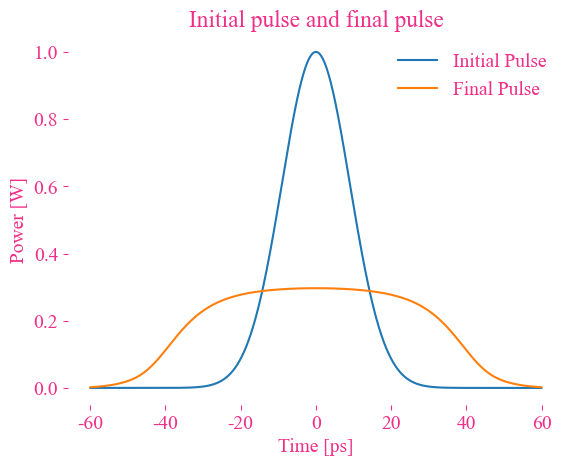

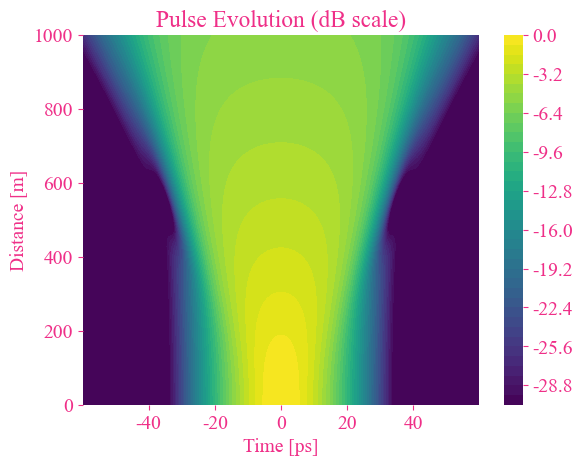

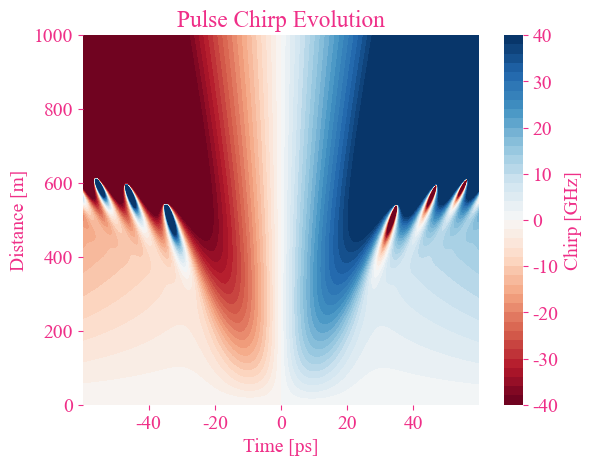

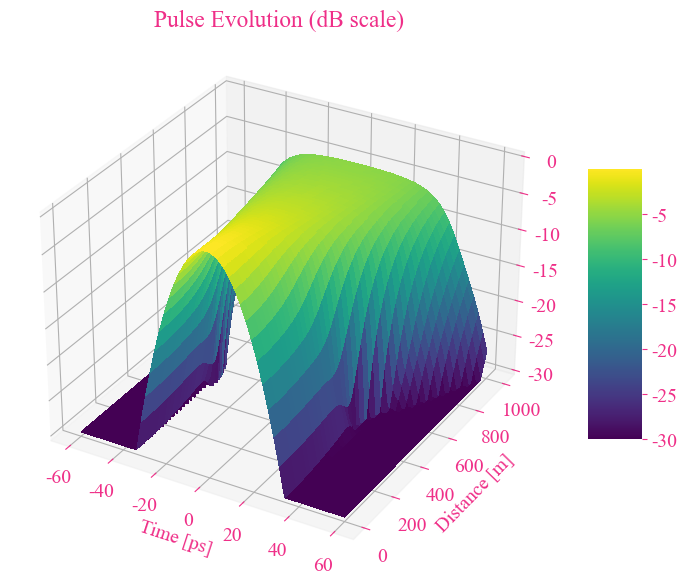

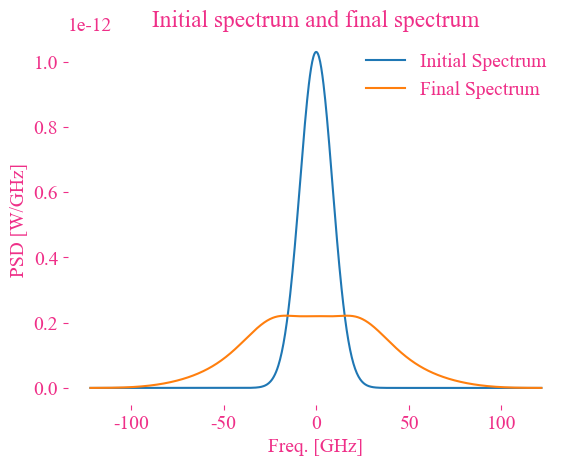

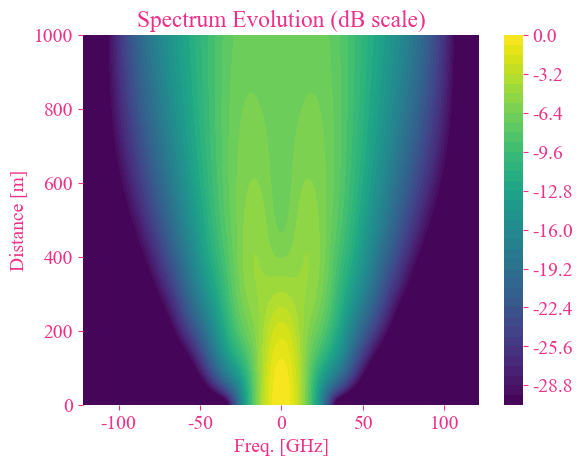

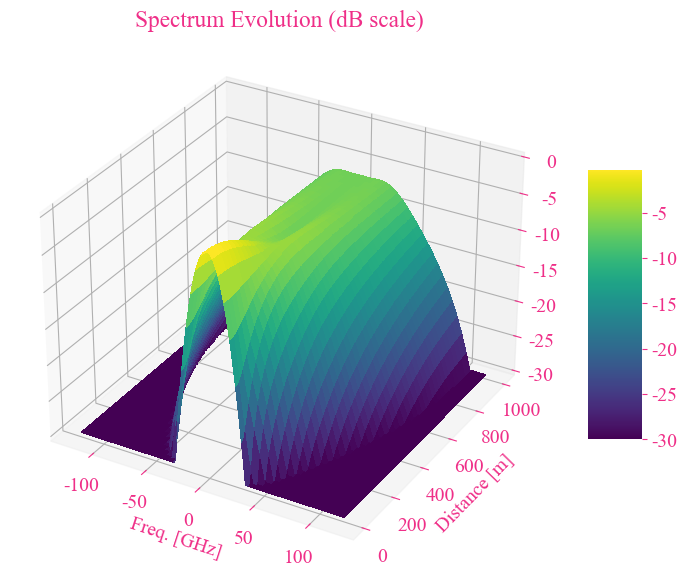

In [17]:


def plotFirstAndLastPulse(matrix,fiber:Fiber_config,sim:SIM_config, nrange:int,**kwargs):
  t=sim.t[int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]*1e12
  plt.figure()
  plt.title("Initial pulse and final pulse")
  plt.plot(t,getPower(matrix[0,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]),label="Initial Pulse")
  plt.plot(t,getPower(matrix[-1,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]),label="Final Pulse")
  #plt.axis([-duration*5*1e12,duration*5*1e12,0,1.05*amplitude**2])
  plt.xlabel("Time [ps]")
  plt.ylabel("Power [W]")
  plt.legend()
  saveplot('first_and_last_pulse',**kwargs)
  plt.show()  


def plotPulseMatrix2D(matrix,fiber:Fiber_config,sim:SIM_config, nrange:int, dB_cutoff,**kwargs):
  #Plot pulse evolution throughout fiber in normalized log scale
  fig, ax = plt.subplots()
  ax.set_title('Pulse Evolution (dB scale)')
  t = sim.t[int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]*1e12
  z = fiber.zlocs 
  T, Z = np.meshgrid(t, z)
  P=getPower(matrix[:,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]  )/np.max(getPower(matrix[:,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]))
  P[P<1e-100]=1e-100
  P = 10*np.log10(P)
  P[P<dB_cutoff]=dB_cutoff
  surf=ax.contourf(T, Z, P,levels=40)
  ax.set_xlabel('Time [ps]')
  ax.set_ylabel('Distance [m]')
  cbar=fig.colorbar(surf, ax=ax)
  saveplot('pulse_evo_2D',**kwargs) 
  plt.show()

def plotPulseMatrix3D(matrix,fiber:Fiber_config,sim:SIM_config, nrange:int, dB_cutoff,**kwargs):
  #Plot pulse evolution in 3D
  fig, ax = plt.subplots(1,1, figsize=(10,7),subplot_kw={"projection": "3d"})
  plt.title("Pulse Evolution (dB scale)")

  t = sim.t[int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]*1e12
  z = fiber.zlocs 
  T_surf, Z_surf = np.meshgrid(t, z)
  P_surf=getPower(matrix[:,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]  )/np.max(getPower(matrix[:,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]))
  P_surf[P_surf<1e-100]=1e-100
  P_surf = 10*np.log10(P_surf)
  P_surf[P_surf<dB_cutoff]=dB_cutoff
  # Plot the surface.
  surf = ax.plot_surface(T_surf, Z_surf, P_surf, cmap=cm.viridis,
                        linewidth=0, antialiased=False)
  ax.set_xlabel('Time [ps]')
  ax.set_ylabel('Distance [m]')
  # Add a color bar which maps values to colors.
  fig.colorbar(surf, shrink=0.5, aspect=5)
  saveplot('pulse_evo_3D',**kwargs)
  plt.show()


def plotPulseChirp2D(matrix,fiber:Fiber_config,sim:SIM_config, nrange:int,**kwargs):
  #Plot pulse evolution throughout fiber in normalized log scale
  fig, ax = plt.subplots()
  ax.set_title('Pulse Chirp Evolution')
  t = sim.t[int(sim_config.number_of_points/2-nrange):int(sim_config.number_of_points/2+nrange)]*1e12
  z = fiber.zlocs 
  T, Z = np.meshgrid(t, z)
  
  Cmatrix=np.ones( (len(z),len(t))  )*1.0

  for i in range(fiber.ntraces):
    Cmatrix[i,:]=getChirp(t/1e12,matrix[i,int(sim_config.number_of_points/2-nrange):int(sim_config.number_of_points/2+nrange)])/1e9


  for kw, value in kwargs.items():
    if kw.lower()=='chirpplotrange' and type(value)==tuple:
      Cmatrix[Cmatrix<value[0]]=value[0]
      Cmatrix[Cmatrix>value[1]]=value[1]
  

  surf=ax.contourf(T, Z, Cmatrix,levels=40,cmap='RdBu')
  
  ax.set_xlabel('Time [ps]')
  ax.set_ylabel('Distance [m]')
  cbar=fig.colorbar(surf, ax=ax)
  cbar.set_label('Chirp [GHz]')
  saveplot('chirp_evo_2D',**kwargs) 
  plt.show()


def plotEverythingAboutPulses(pulseMatrix,fiber:Fiber_config,
                              sim:SIM_config, 
                              nrange:int, 
                              dB_cutoff,
                              **kwargs):
  
  print('  ')
  plotFirstAndLastPulse(pulseMatrix,fiber,sim, nrange,**kwargs)
  plotPulseMatrix2D(pulseMatrix,fiber,sim,nrange,dB_cutoff,**kwargs)
  plotPulseChirp2D(pulseMatrix,fiber,sim,nrange,**kwargs) 
  plotPulseMatrix3D(pulseMatrix,fiber,sim,nrange,dB_cutoff,**kwargs)
  
  print('  ')  


def plotFirstAndLastSpectrum(matrix,fiber:Fiber_config,sim:SIM_config, nrange:int,**kwargs):
  f=sim.f[int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]/1e9
  plt.figure()
  plt.title("Initial spectrum and final spectrum")
  plt.plot(f,getPower(matrix[0,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)])*1e9,label="Initial Spectrum")
  plt.plot(f,getPower(matrix[-1,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)])*1e9,label="Final Spectrum")
  plt.xlabel("Freq. [GHz]")
  plt.ylabel("PSD [W/GHz]")
  plt.legend()
  saveplot('first_and_last_spectrum',**kwargs)
  plt.show()

def plotSpectrumMatrix2D(matrix,fiber:Fiber_config,sim:SIM_config, nrange:int, dB_cutoff,**kwargs):
  #Plot pulse evolution throughout fiber in normalized log scale
  fig, ax = plt.subplots()
  ax.set_title('Spectrum Evolution (dB scale)')
  f = sim.f[int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]/1e9 
  z = fiber.zlocs 
  F, Z = np.meshgrid(f, z)
  Pf=getPower(matrix[:,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]  )/np.max(getPower(matrix[:,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]))
  Pf[Pf<1e-100]=1e-100
  Pf = 10*np.log10(Pf)
  Pf[Pf<dB_cutoff]=dB_cutoff
  surf=ax.contourf(F, Z, Pf,levels=40)
  ax.set_xlabel('Freq. [GHz]')
  ax.set_ylabel('Distance [m]')
  cbar=fig.colorbar(surf, ax=ax) 
  saveplot('spectrum_evo_2D',**kwargs) 
  plt.show()

def plotSpectrumMatrix3D(matrix,fiber:Fiber_config,sim:SIM_config, nrange:int, dB_cutoff,**kwargs):
  #Plot pulse evolution in 3D
  fig, ax = plt.subplots(1,1, figsize=(10,7),subplot_kw={"projection": "3d"})
  plt.title("Spectrum Evolution (dB scale)")

  f = sim.f[int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]/1e9 
  z = fiber.zlocs 
  F_surf, Z_surf = np.meshgrid(f, z)
  P_surf=getPower(matrix[:,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]  )/np.max(getPower(matrix[:,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]))
  P_surf[P_surf<1e-100]=1e-100
  P_surf = 10*np.log10(P_surf)
  P_surf[P_surf<dB_cutoff]=dB_cutoff
  # Plot the surface.
  surf = ax.plot_surface(F_surf, Z_surf, P_surf, cmap=cm.viridis,
                        linewidth=0, antialiased=False)
  ax.set_xlabel('Freq. [GHz]')
  ax.set_ylabel('Distance [m]')
  # Add a color bar which maps values to colors.
  fig.colorbar(surf, shrink=0.5, aspect=5)
  saveplot('spectrum_evo_3D',**kwargs) 
  plt.show()


def plotEverythingAboutSpectra(spectrumMatrix, # 光谱矩阵
                               fiber:Fiber_config, # 光纤属性
                               sim:SIM_config,  # 仿真参数
                               nrange:int, # 画图范围
                               dB_cutoff, # 画图范围
                               **kwargs):
  
  print('  ')  
  plotFirstAndLastSpectrum(spectrumMatrix,fiber,sim, nrange,**kwargs)
  plotSpectrumMatrix2D(spectrumMatrix,fiber,sim,nrange,dB_cutoff,**kwargs)
  plotSpectrumMatrix3D(spectrumMatrix,fiber,sim,nrange,dB_cutoff,**kwargs)

  print('  ')  


#Plot pulses
nrange=600 # 时域的范围 -60，60ps
cutoff=-30 # 时域强度截止值dB

plotEverythingAboutPulses(pulseMatrix,fiber,sim_config,nrange,cutoff,savename='gaussian',chirpPlotRange=(-40,40))

#Plot spectra
nrange=400 # 频域的范围
cutoff=-30 # 频域强度截止值dB
plotEverythingAboutSpectra(spectrumMatrix,fiber,sim_config,nrange,cutoff,savename='gaussian')


#TODO: Make plot of evolution of pulse chirp throughout the fiber

## Test that effect of $\gamma$ only matches theoretical prediction

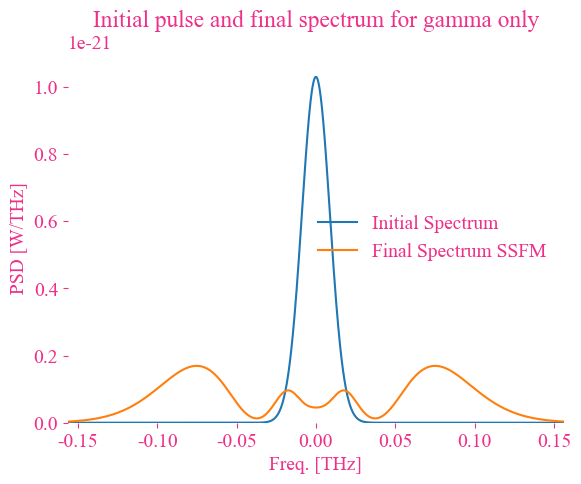

In [18]:
#Define new fiber with only gamma
fiber_gamma_only=Fiber_config(fiber.nsteps, fiber.Length, fiber.gamma, 0, 0)

#Apply theoretical effect of only gamma
finalPulse_gamma_only_theoretical = np.copy(testPulse0)*np.exp(1j*(fiber_gamma_only.Length)*(fiber_gamma_only.gamma)*getPower(testPulse0))


finalSpectrum_gamma_only_theoretical=getSpectrumFromPulse(sim_config.t,finalPulse_gamma_only_theoretical)


#Calculate disperson only effect numerically
_,spectrumMatrix_gamma_only_SSFM = SSFM(fiber_gamma_only,sim_config,testPulse)

finalSpectrum_gamma_only_SSFM = spectrumMatrix_gamma_only_SSFM[-1,:]

#Do the orange and green curves match?
plt.figure()
plt.title("Initial pulse and final spectrum for gamma only")
plt.plot(sim_config.f/1e12,getPower(testSpectrum0),label="Initial Spectrum")
# plt.plot(sim_config.f/1e12,getPower(finalSpectrum_gamma_only_theoretical),label="Final Spectrum theoretical")
plt.plot(sim_config.f/1e12,getPower(finalSpectrum_gamma_only_SSFM),label="Final Spectrum SSFM")
plt.axis([-1/duration*2/1e12,1/duration*2/1e12,0,1.1e-21])
plt.xlabel("Freq. [THz]")
plt.ylabel("PSD [W/THz]")
plt.legend()
plt.savefig('gamma_only0.png', dpi=500, bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()


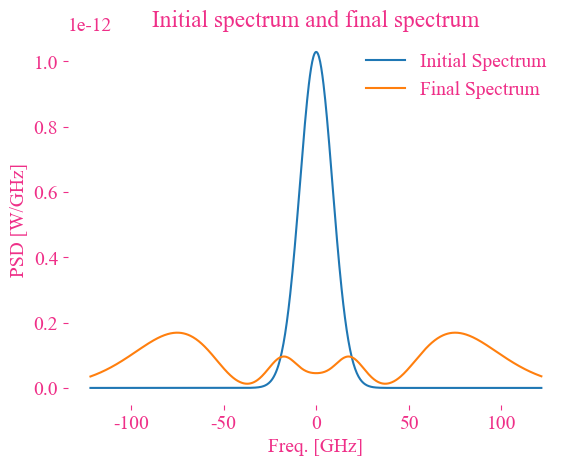

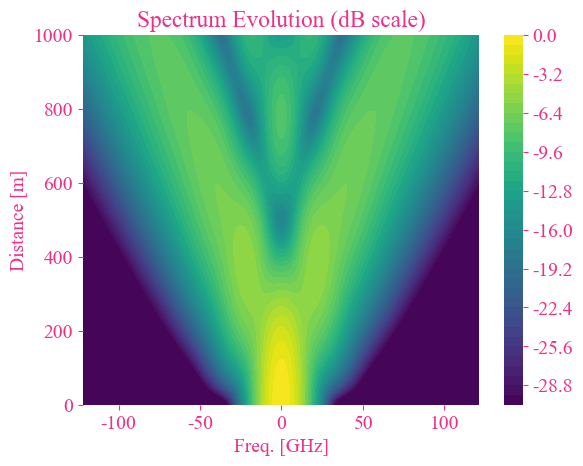

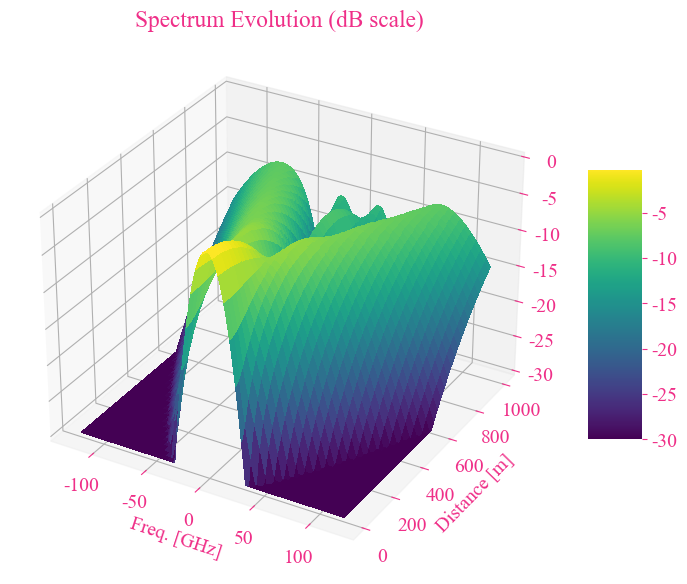

Gamma error computed by energy of difference between theory and SSFM is 0.0008808798301700373
Gamma error computed by difference of energy between theory and SSFM is 1.086675845018785e-13


In [19]:

#Function for optionally saving plots
def saveplot_gamma(basename,**kwargs):
  for kw, value in kwargs.items():
    if kw.lower()=='savename' and type(value)==str:
      savestring=basename+'_'+value
      if value.lower().endswith(('.pdf','.png','.jpg')) == False:
        savestring+='.png'
      plt.savefig(savestring,
                  dpi=500,
                  bbox_inches='tight', 
                  transparent=True,
                  pad_inches=0)

def plotFirstAndLastSpectrum_gamma(matrix,fiber:Fiber_config,sim:SIM_config, nrange:int,**kwargs):
  f=sim.f[int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]/1e9
  plt.figure()
  plt.title("Initial spectrum and final spectrum")
  plt.plot(f,getPower(matrix[0,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)])*1e9,label="Initial Spectrum")
  plt.plot(f,getPower(matrix[-1,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)])*1e9,label="Final Spectrum")
  plt.xlabel("Freq. [GHz]")
  plt.ylabel("PSD [W/GHz]")
  plt.legend()
  plt.savefig('first_and_last_spectrum_gamma.png', dpi=500, bbox_inches='tight', transparent=True, pad_inches=0)
  saveplot_gamma('first_and_last_spectrum_gamma',**kwargs)
  plt.show()

def plotSpectrumMatrix2D_gamma(matrix,fiber:Fiber_config,sim:SIM_config, nrange:int, dB_cutoff,**kwargs):
  #Plot pulse evolution throughout fiber in normalized log scale
  fig, ax = plt.subplots()
  ax.set_title('Spectrum Evolution (dB scale)')
  f = sim.f[int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]/1e9 
  z = fiber.zlocs 
  F, Z = np.meshgrid(f, z)
  Pf=getPower(matrix[:,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]  )/np.max(getPower(matrix[:,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]))
  Pf[Pf<1e-100]=1e-100
  Pf = 10*np.log10(Pf)
  Pf[Pf<dB_cutoff]=dB_cutoff
  surf=ax.contourf(F, Z, Pf,levels=40)
  ax.set_xlabel('Freq. [GHz]')
  ax.set_ylabel('Distance [m]')
  cbar=fig.colorbar(surf, ax=ax) 
  plt.savefig('spectrum_evo_2D_gamma.png', dpi=500, bbox_inches='tight', transparent=True, pad_inches=0)
  saveplot_gamma('spectrum_evo_2D_gamma',**kwargs) 
  plt.show()

def plotSpectrumMatrix3D_gamma(matrix,fiber:Fiber_config,sim:SIM_config, nrange:int, dB_cutoff,**kwargs):
  #Plot pulse evolution in 3D
  fig, ax = plt.subplots(1,1, figsize=(10,7),subplot_kw={"projection": "3d"})
  plt.title("Spectrum Evolution (dB scale)")

  f = sim.f[int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]/1e9 
  z = fiber.zlocs 
  F_surf, Z_surf = np.meshgrid(f, z)
  P_surf=getPower(matrix[:,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]  )/np.max(getPower(matrix[:,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]))
  P_surf[P_surf<1e-100]=1e-100
  P_surf = 10*np.log10(P_surf)
  P_surf[P_surf<dB_cutoff]=dB_cutoff
  # Plot the surface.
  surf = ax.plot_surface(F_surf, Z_surf, P_surf, cmap=cm.viridis,
                        linewidth=0, antialiased=False)
  ax.set_xlabel('Freq. [GHz]')
  ax.set_ylabel('Distance [m]')
  # Add a color bar which maps values to colors.
  fig.colorbar(surf, shrink=0.5, aspect=5)
  plt.savefig('spectrum_evo_3D_gamma.png', dpi=500, bbox_inches='tight', transparent=True, pad_inches=0)
  saveplot_gamma('spectrum_evo_3D_gamma',**kwargs) 
  plt.show()

plotFirstAndLastSpectrum_gamma(spectrumMatrix_gamma_only_SSFM,fiber_gamma_only,sim_config,400)
plotSpectrumMatrix2D_gamma(spectrumMatrix_gamma_only_SSFM,fiber_gamma_only,sim_config,400,cutoff)
plotSpectrumMatrix3D_gamma(spectrumMatrix_gamma_only_SSFM,fiber_gamma_only,sim_config,400,cutoff)

# plotEverythingAboutSpectra(spectrumMatrix_gamma_only_SSFM,fiber_gamma_only,sim_config,200,cutoff)


#Quantify error by looking at the energy of the difference between numerical and theoretical result. 
gamma_err = getEnergy(sim_config.f,(finalSpectrum_gamma_only_SSFM-finalSpectrum_gamma_only_theoretical))/getEnergy(sim_config.f, finalSpectrum_gamma_only_theoretical)
print(f"Gamma error computed by energy of difference between theory and SSFM is {gamma_err}")


#Alternatively, compute the difference of their two energies
gamma_err2 = (getEnergy(sim_config.f,finalSpectrum_gamma_only_SSFM)-getEnergy(sim_config.f,finalSpectrum_gamma_only_theoretical))/getEnergy(sim_config.f, finalSpectrum_gamma_only_theoretical)
print(f"Gamma error computed by difference of energy between theory and SSFM is {gamma_err2}")

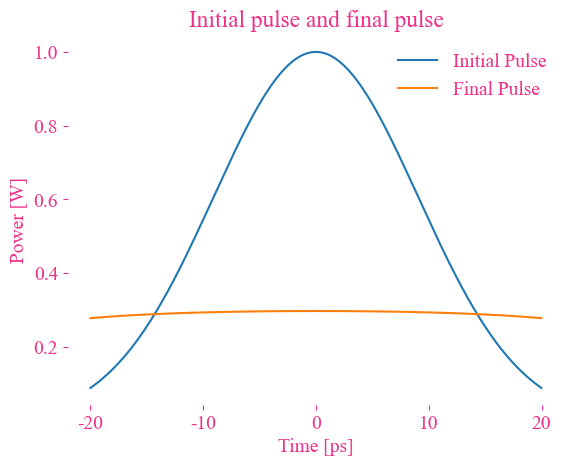

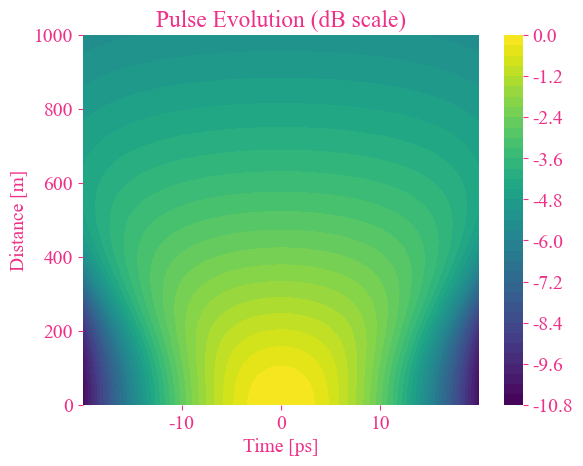

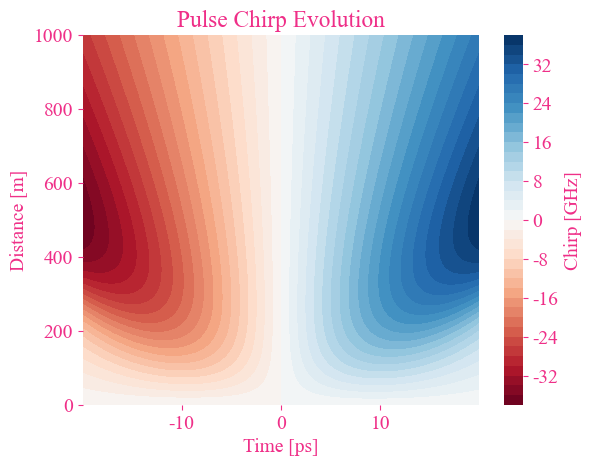

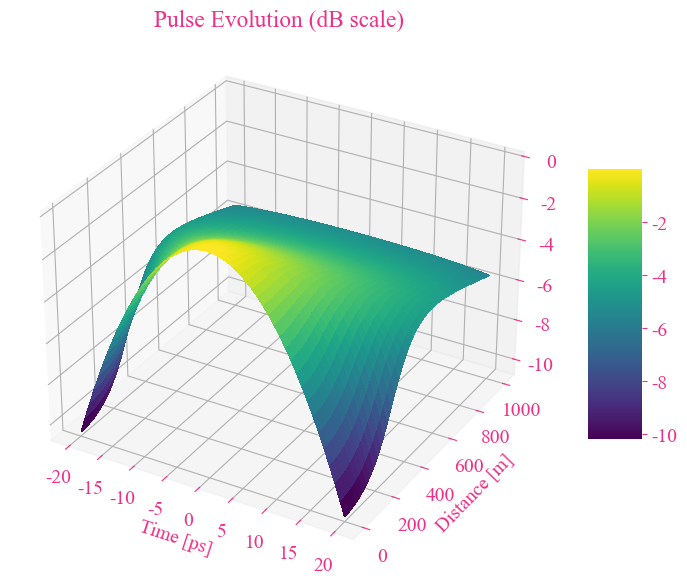

In [20]:
plotEverythingAboutPulses(pulseMatrix,fiber_gamma_only,sim_config,200,cutoff,savename='gaussian',chirpPlotRange=(-40,40))

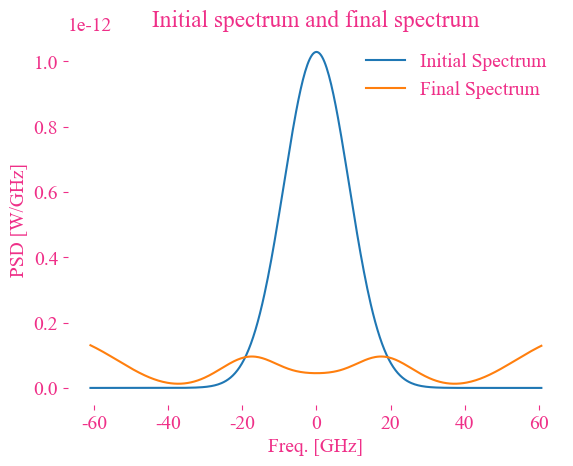

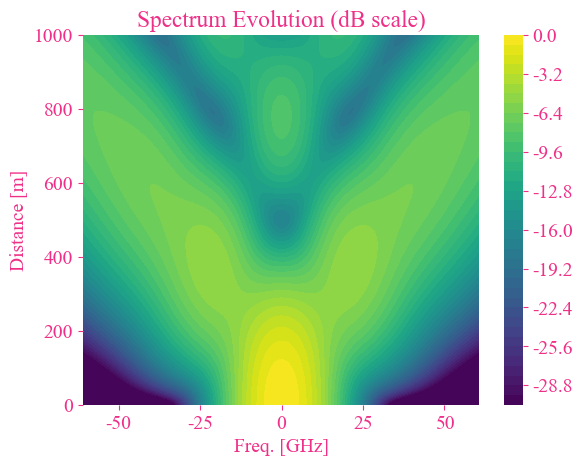

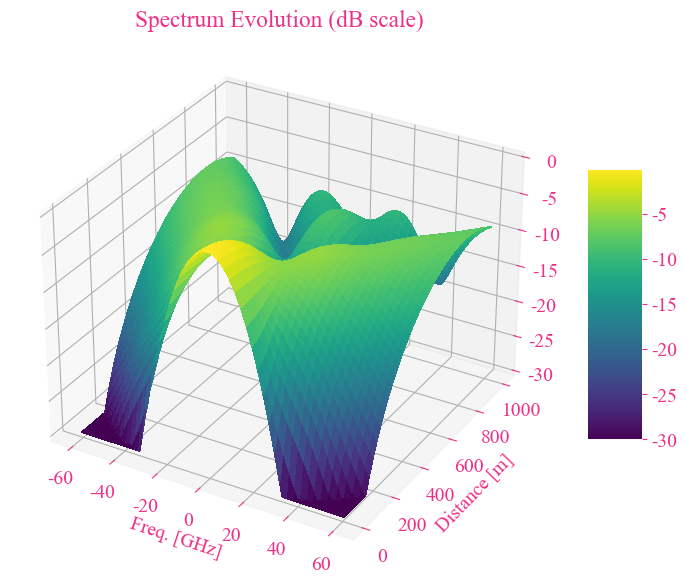

In [21]:
plotEverythingAboutSpectra(spectrumMatrix_gamma_only_SSFM,fiber_gamma_only,sim_config,200,cutoff)